# 目标检测和数据集
## 边缘框
一个边缘框可以通过四个数字定义<br>
* 左上x，左上y，右下x，右下y
* 左上x,y，宽高

<image src='./image/bound.jpg' alt='bound' width=200><br>

## 目标检测数据集
每行代表一个物体
* 图片文件名，物体类别，边缘框

[COCO](cocodataset.org)
* 80物体，330k图片，1.5M物体



## 边缘框实现

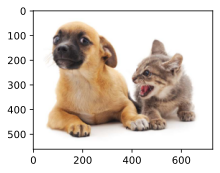

In [3]:
import torch 
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.plt.imread('../img/catdog.jpg')
d2l.plt.imshow(img)

定义在这两种表达之间进行转换的函数

In [6]:
def box_corner_to_center(boxes):
    """从(左上，右下)转换到(中间，高度，宽度)"""
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis = -1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

定义图像中狗和猫的边界框

In [7]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

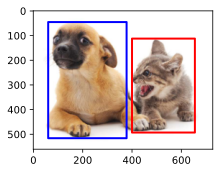

In [8]:
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], fill=False,
                             edgecolor=color, linewidth =2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 目标检测数据集

In [9]:
import os
import pandas as pd
import torch 
import torchvision

d2l.DATA_HUB['banana-detection'] = ( # 香蕉数据集
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

读取香蕉数据集

In [19]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签。"""
    data_dir = d2l.download_extract('banana-detection') # 下载和解压
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', f'{img_name}')))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256 
    # unsqueeze(1) 将形状从 [N, 4] 变为 [N, 1, 4]
    # 归一化 /256 使边界框坐标归一化到 [0, 1) 范围内

自定义一个实例


In [15]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集。"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

为训练集和测试集返回两个数据加载器

In [17]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集。"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

读取小批量，并打印其中的图像和标签形状<br>
每张图片可能有不同多个物体，设置上限，例如认为场景中最多有五个物体

In [ ]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter)) # 拿出一个元素
batch[0].shape, batch[1].shape
# 输出label (batch size, obj num, label+4cor)

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

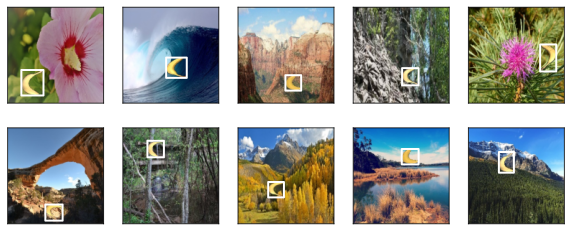

In [ ]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255 # 将维度转换为HWC适配可视化要求，并将像素缩放到01之间
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])
    # * edge_size对应前面压缩回0，1